# QSP Notebook Introduction

QSP Notebook is a proprietary software package that compiles a model, runs simulations, scans parameters, and performs optimizations. These simulations are submitted through python, run on a separate server, and then stored and returned as a set of tables for further analysis within python.

To interface with this software, you will need to create a model file that can be read and converted into a set of ODEs. Within this notebook we will cover

- Writing a simple 2 compartment model in Version 2 of the abm software.
- Generating a Parameter, Dose, and Simulation table
- Submitting a simulation
- Viewing and plotting the output

# Example Model

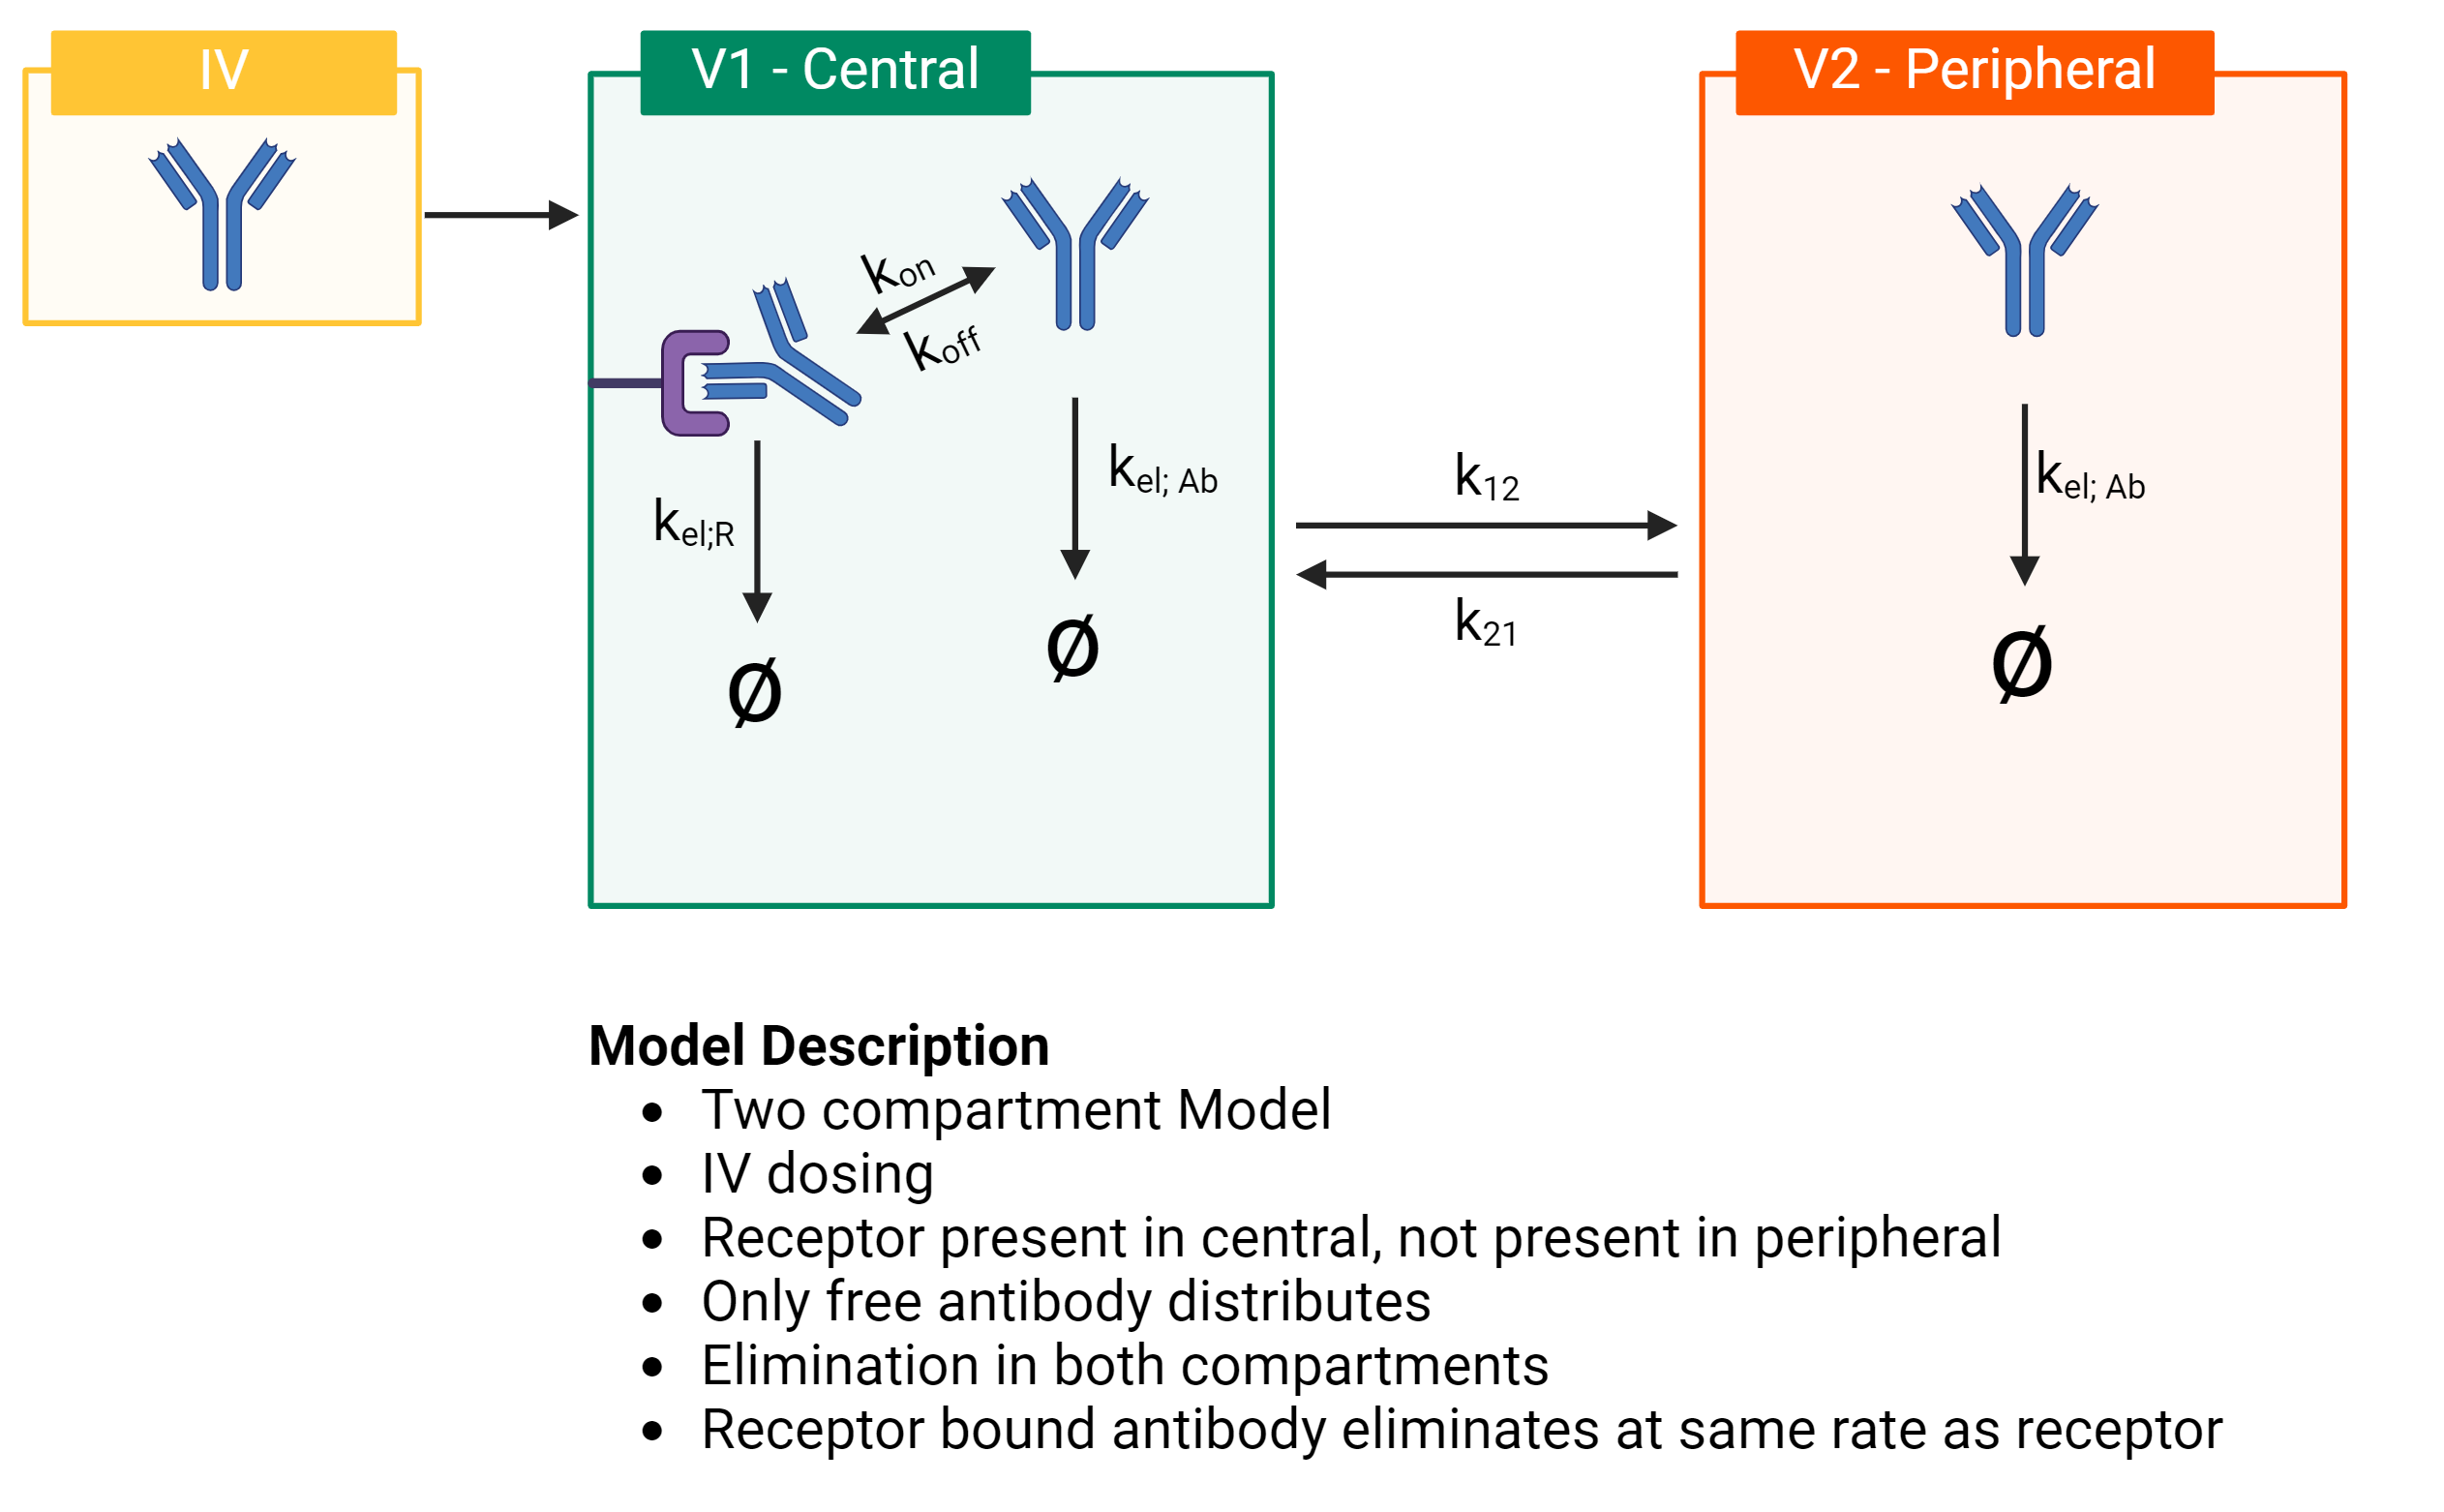

For this example we will use *Macroconstant* parameters to describe all of these rates. Below is the list of relevant macroconstant parameters and their relationship to microconstant parameters:

| Macroconstant | Description | Conversion to microconstants |
|----------------|--------------|--------------------|
| \begin{align}\text{thalf}\end{align} | \begin{align}\text{Half life}\end{align} | $\text{kel} = \frac{\log(2)}{\text{thalf}}$|
| \begin{align}&\text{Pdist}\\& \\&\text{Tdist} \end{align}| \begin{align}& \text{Distribution partition}\\ & \\ & \text{Distribution half time} \end{align}| \begin{align} & \text{k12} = \frac{(\log(2) *  \text{Pdist})/\text{Tdist}}{(\text{Pdist} + (\text{V1}/\text{V2}))} \\ & \\ & \text{k21} = \frac{\log(2)/\text{Tdist}}{(1 + (\text{Pdist} * \text{V2}/\text{V1}))}\end{align}|
|\begin{align}\text{KD}\end{align} | \begin{align}\text{Affinity}\end{align}| $\text{koff} = \text{KD} * \text{kon}$|

It is entirely possible to build your model using the microconstants from the start, but we typically report the macroconstants when presenting our results. For this reason it is useful to simply use the macroconstant method of defining reactions.

# Model File

In the folder `../Model_Files` there should be a file named `ModelFile_blank.model`. This model file has the appropriate structure but is missing all the reactions. We will work our way through the various sections.

## Header
- Comments in this model file, like in python are denoted by a `#`
- Each model file begins with a section that looks like so
  
  ```
  %% ReactionModel@2
  initialization = steady_state(time_scale = 86400:s)
  time_unit = s
  default_state_unit = nmol
  % components
  ```
  The first line starts off the model. The number `2` in this line denotes that this is a Version 2 model file. You can use a Version 1 method as well, but we will focus on the newer version.

  The second line determines the method of initialization. The options are `steady_state` or `initial_value`. The steady state option runs a simulation to steady state with a maximum allowed time value for the steady state calculation in the parenthesis. The initial value option initializes at the values defined later in the model.

  The third and fourth lines define the default time and state units. We typically use seconds and nmol respectively.

## Parameters

The next section is the parameter definitions. These are values that will not change during the simulation and are defined externally.

Each parameter should be defined on a separate line using `parameter:units := value`.

If `value` is a number, it is by default considered unitless. If you are defining parameter values within the model file, any numbers that define values with units must have their appropriate units attached using `:unit` following the value. Units on the left hand side of this equation are optional and are used to assert that the units on the right hand side are equivalent to the declared units. 

Many modelers do not include explicit parameter values within the model file. Instead choosing to use `parameter:units := nan` within the model file and using a parameter table to define the parameter values. This method is useful because it allows for easier modification of parameter values and allows for simpler QC to ensure the desired parameter values are being used. If you use `nan` to define the value of the parameter on the right hand side, you MUST include units on the left hand side.

### Parameter Task
Add the following parameter definitions into your model in the space provided

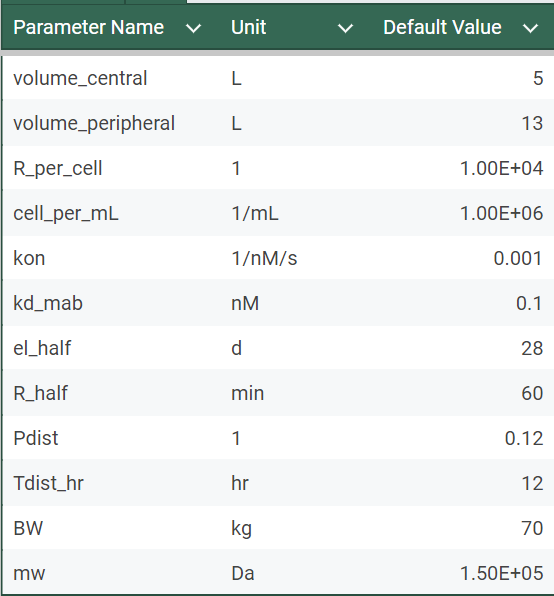

## Assignments

This next section is used to define assignments. These are any values that are calculated, but not defined externally. Assignments are defined using `assignment:unit = value or expression`.

There are three main types of assignments used in models

1. unit conversion rules (for example `mL_per_L:(mL/L) = 1000:(mL/L)`
2. functions of parameters (for example `thalf_s:s = thalf_h * 3600:(s/hr)`. Note that if a parameter or assignment whose units have already been defined appears on the right hand side of another assignment, units do not need to be included)
3. functions of states (for example `drug_concentration:nM = drug_amount / volume`)
### Assignment Task

Create assignments to calculate the initial state values
- `total_cells_central`
- `total_R1_central`

## Routes
Routes are how doses are delivered into the model. There are three main options for including dose routes

1. List schedule: `@(times = ..., amounts = ..., durations = ...)`
2. Repeat schedule: `@(start = ..., interval = ..., n = ..., amount = ..., duration = ...)`
3. null: `@()`

It is usually recommended to use a null route in your model file. This allows the dose amount and dose frequency to be defined externally to your model. If you use a List Schedule or Repeat Schedule route, the route will remain "on" for all simulations. Using the null schedule option allows you to define multiple possible routes and select which is run for each simulation.

A null route is define with the following syntax

`Route_name: (units) = @();  State += amt * Conversion_to_state_units`

As this can be a little confusing, your model file comes with a prepared null route.

### Route Task
Check that you understand the conversion between the dosed `amt` and the change the the state variable

## Compartments
Compartments are how the model defines the appropriate volumes for each state variable. The syntax of a compartment is `name~dimension = size`

- The name of a compartment is typically the tissue name. This should be one word
- The dimension of the compartment determines the types of reactions you expect. For most compartments you will use a dimension of 3. For cases where you have only membrane bound states interacting and you want second order reactions (like in our TCE template model) you will set the dimension to a state equal to 2.

### Compartment Task
Define two compartments with dimension 3 and volume equal to the appropriate parameter

1. `central`
2. `peripheral`

## States
In this section you list all state variables, assign them to their appropriate compartment, and define their initial values. The sytax of defining a state is `name@compartment: unit *= initial_value`.

If you are using the `steady_state` initialization, the initial value of your state only affects the amount of time/computational power necessary to initialize. If possible, it is recommended that you calculate the desired initial values even when using the `steady_state` initialization.

### State Task
Define 4 states for the model

1. `R1_central`: free receptor in the central compartment
2. `Ab1_00_central`: free drug in the central compartment
3. `Ab1_R1_central`: bound drug:receptor in the central compartment
4. `Ab1_peripheral`: free drug in the peripheral compartment

Choose the appropriate initial conditions

## Reactions
This section is used for all the reactions. We define reactions using arrows.

The general syntax of a reaction is 

`States before <-> States after ; kf = forward rate constant, kr = reverse rate constant`

If a reaction is irreversible, you may use just the forward arrow (`->`) and leave off the `kr` term.

The forward and reverse rate constants are the general rate constants used when defining a reaction. If you wish to explicitly write out the reaction rate (the derivative due to this specific reaction) you can use 

`States before <-> States after ; rf = forward rate, rr = reverse rate`

Besides these general forms, we also have specific inputs that read in Macroconstant parameters

| Reaction Type | Code | Notes |
|-|-|-|
|Synthesis/Degradation | ` <-> State; css = steady_state_concentration, thalf = Half_Life`| The `css` must be a *concentration*. The `thalf` must be defined in the same units as the default time units in the model file|
|Degradation| `State -> ; thalf = Half_life`| The `thalf` must be defined in the same units as the default time units in the model file|
|Binding| `A + B <-> C; kd = KD, kon = k_on` | The `kd` term must be in units consistent with the state units divided by the compartment volume units. The `kon` value must be in units consistent with `1/(state unit / volume unit)/time unit`|
|Transport| `A_compartment1 <-> A_compartment2; pdist = Pdist, tdist = Tdist`| The units of `Pdist` are 1 and the value should give you the steady state ratio of the concentration in compartment1 to compartment2. The units of `tdist` should match the default time units in the model file|

There are additional "special" reaction types. Those are not necessary for this example but you can find more information in the `abm-platform-training/examples/01_reaction_model_functions` folder

### Reaction Task
Define 6 reactions using the states in the previous section

1. Synthesis/Degradation of receptor in the central compartment
2. Degradation of free drug in the central compartment
3. Degradation of bound drug:receptor in the central compartment
4. Degradation of free drug in the peripheral comaprtment
5. Binding/unbinding of drug to receptor in the central compartment
6. Transport of free drug between the central and peripheral compartment

## Model Readouts
This section is used to define an additional set of assignments that provide easy to understand and read outputs for the model. These may be exactly the same as a state variable, but with a different name, a combination or sum of several state variables, or a transformation of a state variable (say nmol to nM).

The syntax of a model readout is the same as an assignment `name:unit = value`

### Model readout Task
Define 5 model readouts:

1. `free_R1_central` with units `nmol` (this should be identical to one of the state variables)
2. `free_drug_central` with units `nmol` (this should be identical to one of the state variables)
3. `bound_drug_central` with units `nmol` (this should be identical to one of the state variables)
4. `total_drug_central` with units of `nmol` (this should be a sum of two state variables)
5. `RO` with units `1` (this should be the percent of receptor that is bound)

# Running the simulation
Now that you have a model file, we are ready to start setting up our simulation.

## Load packages
We first have to load the necessary packages. The only additional package we will need to load besides `numpy`, `pandas`, and `plotnine` is the package containing QSP Notebook `abm`.

Run a cell with
```
import numpy as np
import pandas as pd
from plotnine import *
from abm import *
```

## Setting up the tables
There are several tables that are necessary to interface with the simulation software. These are the Parameter table, Dose table, and Simulation table. If you defined your parameters explicitly in the model, you can avoid using the Parameter table - but I would not usually recommend that.

You can create these tables either through your favorite csv editor or using pandas. For this workshop you will find a filled in Parameter table, and a blank Dose and Simulation table in the `../Tables` directory

### Parameter Table
For simulations a parameter table is required to have 3 columns

1. `parameter` - this is the parameter
2. `value` - this is the value of the parameter
3. `unit` - this is the parameter value

You can add optional "label" columns to distibguish between mutliple conditions (ie high and low expression might have different `R_per_cell` values). For more details regarding how to use labels, see the tutorials in the `abm-platform-training/examples/09_complete_workflows` directory

### Dose Table
This table defines the doses, routes, and frequency of drug delivery. There are 6 required columns

1. A label column - This is how the specific delivery condition will be named and called. In most cases, this can simply be the same as the dose so the column is often called something like "dose_mpk"
2. `route` - This column specifies which route is used for delivery. In our example, there is only one route option "IV_mpk".
3. `amounts` - This is the amount of drug to be delivered
4. `amount_unit` - The unit that the amount is listed in. This may be different from the unit defined in the model, but it must be a consistent unit type. ie if your model units are "mg/kg" you may use "g/kg" in the dose table, but you may NOT use "mg".
5. `times` - This column denotes when the dose should be applied
6. `time_unit` - This column denots the units of the time when the dose should be applied. This does not need to be the same unit as your default model file, but must be a valid time unit

### Simulation Table
This is a table containing the same lable column as the Dose Table with row entries equivalent to which specific conditions you want to simulate. If you want to simulate all the conditions in the Dose table, this will be simply the unique label rows. But if you want to simulate only a subset of these conditions, then your simulation table will be a subset of the possible label values.

### Table Task
- Fill in the empty dose table in the `../Tables` folder. Set up the table such that there are 4 dose levels (0.01 mg/kg, 0.03 mg/kg, 0.1 mg/kg, and 0.3 mg/kg). Each dose should be applied at 3 time points (0 days, 7 days, 14 days)
- Fill in the empty simulation table in the `../Tables` folder. Set up the table such that all dose levels in the dose table are simulated.

## Submitting a simulation
To run a simulation you must use the `simulate` function in the `abm` package.

- The `models` input is the model file location.
- The `parameters` input is either the parameter file location or a loaded parameter table
- The `simulations` input is either the simulation file location or a loaded simulation table
- The `doses` input is either the dose file location or a loaded dose table
- The `times` input is the times at which you would like the simulation saved. This can either be a list of times with format `['time:unit']` or you can use the function `linspace(start, stop, count, unit)` from the `abm` package.
- The `outputs` input is a list of output state names you would like saved.

Here is the syntax:
```
simulate(models = {Model File},
        parameters = {Parameter Table},
        doses = {Dose Table},
        simulations = {Simulation Table},
        outputs = {Output List},
        times = {Times List or Table}).to_pandas(tall_outputs = True)
```

### Simulation Task
- Load the paramter table, dose table, and simulation table as `Tpar`, `Tdos`, and `Tsim`
- Fill in the following code with the model file, parameter table, dose table, and simulation table
    - select RO as your output
    - select days 0 - 21 with 211 samples as your time outputs

In [1]:
#Load the parameter table, dose table, and simulation table


Copy the following code to create a run a simulation object, and fill in the inputs

```
Tres = simulate(models = ,
                parameters = ,
                doses = ,
                simulations = ,
                outputs = ,
                times = ).to_pandas(tall_outputs = True)
```

In [2]:
#use this cell to display the output


### Plotting assignment
Plot the RO over time - use the information you learned from the previous workshops